In [2]:
pip install dill

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### What are NF Nets?
NF Nets: Normalizer Free Neural Networks

In [4]:
%cd ./nfnets_pytorch


/Users/meriselleruotolo/workspace/CTPSpring2021_DataScience_Proj/nfnets_pytorch


In [5]:
# imports
import argparse
import math
import PIL
import time
import yaml
import numpy as np
import random
import copy

from pathlib import Path
from PIL.Image import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision import transforms

from nfnets import NFNet, SGD_AGC, pretrained_nfnet

from sklearn.model_selection import train_test_split


In [6]:
import torch
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

    # need to do in terminal later:
    # !git clone https://github.com/benjs/nfnets_pytorch
    # also check folder names

In [7]:
batch_size = 64

data_path = '../fruits-360/Training/'

fruit_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((192,192)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]),
    ])
)

In [8]:
fruit_datasets[0]

(tensor([[[2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [9]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(fruit_datasets))), 
                                          test_size=0.4, 
                                          random_state=random_seed)

dataset['train'] = Subset(fruit_datasets, train_idx)
valtest          = Subset(fruit_datasets, valtest_idx)

val_ds, test_ds = train_test_split(list(range(len(valtest))),
                                  test_size = 0.5,
                                  random_state = random_seed)

dataset['valid'] = Subset(valtest, val_ds)
dataset['test'] = Subset(valtest, test_ds)
        
max_trn_corrects = len(dataset['train'])
max_val_corrects = len(dataset['valid'])


In [10]:
dataloaders, batch_num = {}, {}

dataloaders['train'] = DataLoader(dataset['train'],
                                 batch_size = batch_size,
                                 shuffle = True,
                                 num_workers = 8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                 batch_size = batch_size, 
                                 shuffle = True,
                                 num_workers = 8)
dataloaders['test'] = DataLoader(dataset['test'],
                                batch_size = batch_size,
                                shuffle=True,
                                num_workers = 8)

batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])

print('batch_size : {}\ntrain/valid/test : {}/{}/{}'
     .format(batch_size,
            batch_num['train'],
            batch_num['valid'], 
            batch_num['test']))

batch_size : 64
train/valid/test : 635/212/212


torch.Size([3, 192, 192])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


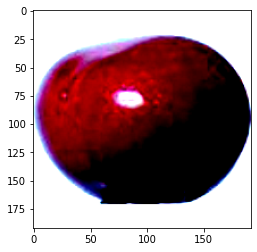

In [11]:
imgtest = None
for images, labels in dataloaders['train']:
    imgtest = images[3]
    print(imgtest.shape)
    break
    
imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
imshow(imgtest)

In [12]:
model = NFNet(
            num_classes=1000,
            variant ='F0',
            stochdepth_rate =0.25,
            alpha=0.2,
            se_ratio=0.5,
            activation = 'gelu'
)

optimizer = SGD_AGC(
    named_params=model.named_parameters(),
    lr=0.1,
    momentum=0.9,
    clipping=0.1,
    weight_decay = 0.0002,
    nesterov =True)

criterion = nn.CrossEntropyLoss()

#dev = torch.device("cuda") # double check ??????
#model.to(dev)


In [13]:
for params in optimizer.param_groups:
    name = params['name']
    
    if model.exclude_from_weight_decay(name):
        params['weight_decay'] = 0
    if model.exclude_from_clipping(name):
        params['clipping'] = None

In [15]:
since = time.time()
num_epochs = 15
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0

best_model = copy.deepcopy(model.state_dict())


In [ ]:
for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    # train stage
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
       # data, target = data.to(dev), target.to(dev)                 # to devv

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    # evaluation stage
    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            #val_data, val_target = val_data.to(dev), val_target.to(dev)            #dev
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    # saving train & validation accuracy
    trn_acc_list.append(trn_corrects / max_trn_corrects * 100)
    val_acc_list.append(val_corrects / max_val_corrects * 100)
    
    # saving train & validation loss
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed"
          .format(epoch+1, num_epochs, 
                  trn_loss / batch_num['train'], 
                  val_loss / batch_num['valid'], 
                  time_elapsed // 60, time_elapsed % 60))

    # update the best model if current model has higher accuracy
    if val_corrects / max_val_corrects * 100 > best_acc:
        best_acc = val_corrects / max_val_corrects * 100
        best_model = copy.deepcopy(model.state_dict())
        print("best model updated-epoch: {} | val_accuracy: {:.4f}"
            .format(epoch+1, best_acc))

time_elapsed = time.time() - since


In [ ]:
print('Training complete in {:.0f}m {:.0f}s'
      .format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.2f' %(best_acc))

# save best model to best_model.pt
model.load_state_dict(best_model)
torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
print("model saved")

In [ ]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')

plt.legend()

In [ ]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

In [ ]:
# real test folder data
batch_size = 64

data_path = '/kaggle/input/fruits/fruits-360/Test'

test_fruit = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((192, 192)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

test_data = DataLoader(test_fruit,
                      batch_size=batch_size, shuffle=True,
                      num_workers=8)


print('batch_size : {}\ntest : {}'
      .format(batch_size, len(test_data)))

In [ ]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(test_data):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))